#### Chain Of Thoughts With RAG
What is Chain-of-Thought (CoT) in RAG?

CoT reasoning breaks down a complex question into intermediate steps, and allows retrieval + reflection at each step before answering.

User Query
   ↓
- Step 1: Decompose question → sub-steps (Reason)
- Step 2: Retrieve docs per step (Act)
- Step 3: Combine context (Observe)
- Step 4: Final answer generation (Reflect)

In [ ]:
import os
from typing import List
from pydantic import BaseModel
# from langchain.schema import Document
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import TextLoader
# from langchain.vectorstores import FAISS
from langchain_community.vectorstores import FAISS
# from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langgraph.graph import StateGraph, END

In [2]:
# -------------------------------
# 1. Prepare Vectorstore
# -------------------------------
docs = TextLoader("research_notes.txt",encoding="utf-8").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)
embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

In [3]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o")

In [4]:
# -------------------------------
# 2. LangGraph State Definition
# -------------------------------
class RAGCoTState(BaseModel):
    question: str
    sub_steps: List[str] = []
    retrieved_docs: List[Document] = []
    answer: str = ""

In [5]:
# -------------------------------
# 3. Nodes
# -------------------------------

# a. Plan sub-questions
def plan_steps(state:RAGCoTState)->RAGCoTState:
    prompt=f"Break the question into 2-3 reasoning steps: \n\n {state.question}"
    result=llm.invoke(prompt).content
    subqs=[line.strip("- ") for line in result.split("\n") if line.strip()]

    return state.model_copy(update={"sub_steps":subqs})


In [6]:
# b. Retrieve for each step
def retrieve_per_step(state:RAGCoTState)-> RAGCoTState:
    all_docs=[]
    for sub in state.sub_steps:
        docs = retriever.invoke(sub)
        all_docs.extend(docs)
    return state.model_copy(update={"retrieved_docs": all_docs})


In [7]:
# c. Generate Final Answer
def generate_answer(state: RAGCoTState) -> RAGCoTState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
You are answering a complex question using reasoning and retrieved documents.

Question: {state.question}

Relevant Information:
{context}

Now synthesize a well-reasoned final answer.
"""
    result = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"answer": result})

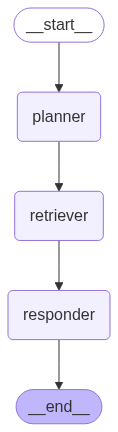

In [8]:
# -------------------------------
# 4. LangGraph Graph
# -------------------------------
builder = StateGraph(RAGCoTState)
builder.add_node("planner", plan_steps)
builder.add_node("retriever", retrieve_per_step)
builder.add_node("responder", generate_answer)

builder.set_entry_point("planner")
builder.add_edge("planner", "retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()
graph

In [9]:
# -------------------------------
# 5. Run CoT RAG Agent
# -------------------------------
if __name__ == "__main__":
    query = "what are the additional eperiments in Transformer eveluation?"
    state = RAGCoTState(question=query)
    final = graph.invoke(state)

    print("\n🪜 Reasoning Steps:", final["sub_steps"])
    print("\n✅ Final Answer:\n", final["answer"])


🪜 Reasoning Steps: ['To determine additional experiments in Transformer evaluation, you can break it down into the following reasoning steps:', '1. **Identify Key Evaluation Areas:**', 'Consider the fundamental aspects of Transformer models that merit evaluation, such as accuracy, efficiency, robustness, and interpretability.', 'Think about any limitations or areas where traditional evaluations may fall short and require more insight.', '2. **Design Experiment Categories:**', 'Determine the types of additional experiments that could address these areas. This may include stress-testing for robustness, probing experiments for understanding model internals, efficiency evaluations with various hardware settings, or fairness assessments to see if the model is biased.', '3. **Refine and Specify Experiments:**', 'For each category, outline specific experiments. For instance, you might design adversarial testing experiments to test robustness or efficiency benchmarks across different computat